In [1]:
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

In [2]:
!git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 14366, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 14366 (delta 63), reused 71 (delta 31), pack-reused 14242
Receiving objects: 100% (14366/14366), 13.70 MiB | 33.01 MiB/s, done.
Resolving deltas: 100% (9870/9870), done.


In [3]:
!mv yolov5/* ./


In [4]:
!pip install -r requirements.txt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 27.8 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 10.4 MB/s 


In [5]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ebrahimhaquebhatti","key":"3920b05dcfcbe9905255815ee523942e"}'}

In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/


In [7]:
! chmod 600 ~/.kaggle/kaggle.json


In [8]:
 ! kaggle datasets list


ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           5751        172  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27            940         23  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           3804         89  1.0              
thedevastator/how-much-sleep-do-americans-really-get        

In [10]:
! kaggle competitions download global-wheat-detection

 98% 597M/607M [00:04<00:00, 148MB/s]
100% 607M/607M [00:04<00:00, 140MB/s]


In [11]:
!unzip global-wheat-detection.zip -d wheat_data


Archive:  global-wheat-detection.zip
  inflating: wheat_data/sample_submission.csv  
  inflating: wheat_data/test/2fd875eaa.jpg  
  inflating: wheat_data/test/348a992bb.jpg  
  inflating: wheat_data/test/51b3e36ab.jpg  
  inflating: wheat_data/test/51f1be19e.jpg  
  inflating: wheat_data/test/53f253011.jpg  
  inflating: wheat_data/test/796707dd7.jpg  
  inflating: wheat_data/test/aac893a91.jpg  
  inflating: wheat_data/test/cb8d261a3.jpg  
  inflating: wheat_data/test/cc3532ff6.jpg  
  inflating: wheat_data/test/f5a1f0358.jpg  
  inflating: wheat_data/train.csv    
  inflating: wheat_data/train/00333207f.jpg  
  inflating: wheat_data/train/005b0d8bb.jpg  
  inflating: wheat_data/train/006a994f7.jpg  
  inflating: wheat_data/train/00764ad5d.jpg  
  inflating: wheat_data/train/00b5c6764.jpg  
  inflating: wheat_data/train/00b5fefed.jpg  
  inflating: wheat_data/train/00b70a919.jpg  
  inflating: wheat_data/train/00e903abe.jpg  
  inflating: wheat_data/train/00ea5e5ee.jpg  
  inflating: 

In [12]:
# read the training data.


df = pd.read_csv('/content/wheat_data/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0
from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]

In [13]:
df.head()


image_id      x      y      w      h  x_center  y_center  classes
0  b6ab77fd7  834.0  222.0   56.0   36.0     862.0     240.0        0
1  b6ab77fd7  226.0  548.0  130.0   58.0     291.0     577.0        0
2  b6ab77fd7  377.0  504.0   74.0  160.0     414.0     584.0        0
3  b6ab77fd7  834.0   95.0  109.0  107.0     888.5     148.5        0
4  b6ab77fd7   26.0  144.0  124.0  117.0      88.0     202.5        0

In [14]:
index = list(set(df.image_id))
len(index)

3373

In [15]:
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/wheat_data/{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/3373 [00:00<?, ?it/s]

In [16]:
%%writefile ./convertor/wheat0.yaml

# COCO 2017 dataset http://cocodataset.org - first 128 training images
# Download command:  python -c "from yolov5.utils.google_utils import gdrive_download; gdrive_download('1n_oKgR81BJtqk75b00eAjdv03qVCQn2f','coco128.zip')"
# Train command: python train.py --data ./data/coco128.yaml
# Dataset should be placed next to yolov5 folder:
#   /parent_folder
#     /coco128
#     /yolov5


# train and val datasets (image directory or *.txt file with image paths)
train: ./convertor/fold0/images/train2017/
val: ./convertor/fold0/images/val2017/

# number of classes
nc: 1

# class names
names: ['wheat']

Writing ./convertor/wheat0.yaml


In [17]:
%%writefile ./convertor/yolov5x.yaml



# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [116,90, 156,198, 373,326]  # P5/32
  - [30,61, 62,45, 59,119]  # P4/16
  - [10,13, 16,30, 33,23]  # P3/8

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
  ]

# YOLOv5 head
head:
  [[-1, 3, BottleneckCSP, [1024, False]],  # 9

   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 18 (P3/8-small)

   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 22 (P4/16-medium)

   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 26 (P5/32-large)

   [[], 1, Detect, [nc, anchors]],  # Detect(P5, P4, P3)
  ]

Writing ./convertor/yolov5x.yaml


In [18]:
!python /content/train.py --img 1024 --batch 16 --epochs 10 --data /content/convertor/wheat0.yaml --name yolov5x_fold0 

train: weights=yolov5s.pt, cfg=, data=/content/convertor/wheat0.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_fold0, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-12-6 Python-3.8.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anch

In [19]:
# get a list of experiments
exp_list = os.listdir('/content/runs/train')

# Get the latest exp.

exp = exp_list[-1]

exp

'yolov5x_fold0'

In [24]:
!python /content/detect.py --weights runs/train/yolov5x_fold0/weights/best.pt --img 1024  --source /content/convertor/fold0/images/val2017 


detect: weights=['runs/train/yolov5x_fold0/weights/best.pt'], source=/content/convertor/fold0/images/val2017, data=data/coco128.yaml, imgsz=[1024, 1024], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2022-12-6 Python-3.8.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/674 /content/convertor/fold0/images/val2017/00333207f.jpg: 1024x1024 56 wheats, 23.3ms
image 2/674 /content/convertor/fold0/images/val2017/005b0d8bb.jpg: 1024x1024 27 wheats, 23.4ms
image 3/674 /content/convertor/fold0/images/val2017/00ea5e5ee.jpg: 1024x1024 55 wheats, 23.4ms
image 4/674 /content/convertor/fold0/

In [23]:
os.listdir('/content/runs/train')


['yolov5x_fold0', 'exp']

In [ ]:
# Display the contents of the "exp" folder
os.listdir(f'/content/runs/train/{exp}')

['PR_curve.png',
 'events.out.tfevents.1669917201.8abf9c21e199.220.0',
 'results.csv',
 'confusion_matrix.png',
 'val_batch1_pred.jpg',
 'train_batch2.jpg',
 'train_batch1.jpg',
 'val_batch2_labels.jpg',
 'hyp.yaml',
 'F1_curve.png',
 'val_batch0_pred.jpg',
 'val_batch0_labels.jpg',
 'R_curve.png',
 'labels_correlogram.jpg',
 'val_batch1_labels.jpg',
 'labels.jpg',
 'weights',
 'opt.yaml',
 'train_batch0.jpg',
 'results.png',
 'val_batch2_pred.jpg',
 'P_curve.png']

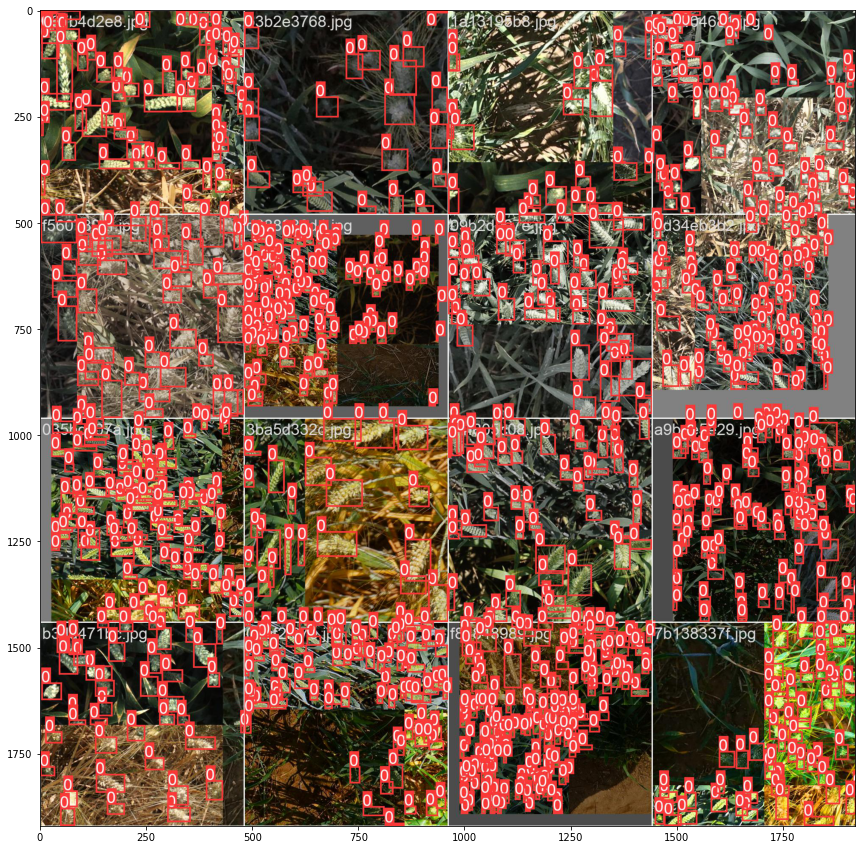

In [25]:
# One mosaic batch of train images with labels

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/train_batch0.jpg'))

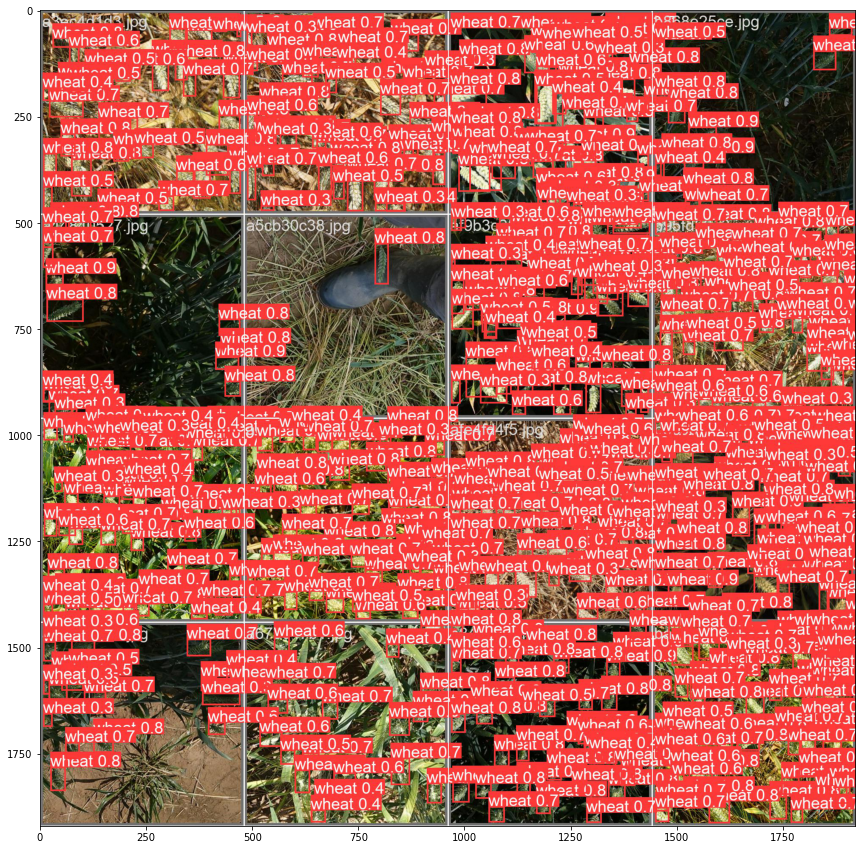

In [ ]:
# One batch of val images with true labels

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/val_batch1_pred.jpg'))

In [ ]:
plt.imshow(plt.imread(f'runs/train/{exp}/val_batch1_pred.jpg'))